# Random-Walk and Diffusion-based Methods

Although this book puts a heavy emphasis on spectral methods, there are many ways in which you can learn lower-dimensional representations for networks which don't involve spectral approaches. As opposed to spectral methods, a **random walk on a network** is a random process which focuses on the analysis of paths which start at a node in the network, and proceed to generate successions of random steps to other nodes in the network. The manner in which these random processes materialize is a function of the topology of the random network, including the nodes, edges, and (optionally, if the network is weighted), the edge weights. 

## A simplified random walk on a network

For instance, let's consider an extremely simplified approach for a random walk on the network that you saw back in [Chapter 4](#link?), which was our New York example. To begin, let's redefine the nodes and edges of the network. The nodes of the network are the five boroughs of New York City (Staten Island SI, Brooklyn BK, Queens Q, the Bronx BX, and Manhattan MH). The nodes in your network are the five boroughs. The edges $(i,j)$ of your network exist if one can travel from borough $i$ to borough $j$ along a bridge.

Below, you will look at a map of New York City, with the bridges connecting the different boroughs. In the middle, you look at this map as a network layout plot. The arrows indicate the direction of travel. On the right, you look at this map as an adjacency matrix:

In [14]:
import numpy as np

# define the node names
node_names = ["SI", "MH", "BK", "Q", "BX"]
# define the adjacency matrix
A = np.array([[0,0,1,0,0],  # staten island is neighbors of brooklyn
              [0,0,1,1,1],  # manhattan is neighbors of all but staten island
              [1,1,0,0,0],  # brooklyn is neighbors of staten island and manhattan
              [0,1,0,0,1],  # queens is neighbors of manhattan and bronx
              [0,1,0,1,0]]) # bronx is neighbors of manhattan and queens

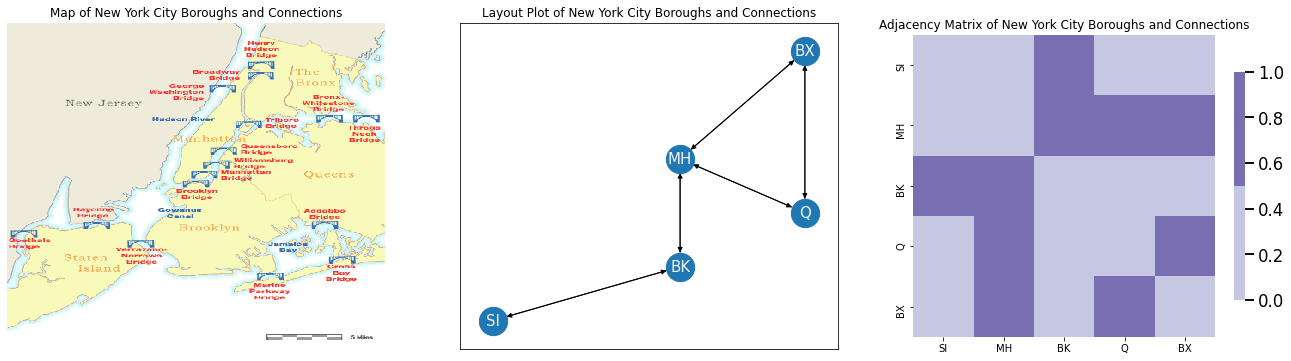

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from graphbook_code import heatmap

img = mpimg.imread('../ch4/img/newyork.png')

G = nx.DiGraph()

G.add_node("SI", pos=(1,1))
G.add_node("MH", pos=(4,4))
G.add_node("BK", pos=(4,2))
G.add_node("Q", pos=(6,3))
G.add_node("BX", pos=(6,6))

pos = nx.get_node_attributes(G, 'pos')
G.add_edge("SI", "BK")
G.add_edge("MH", "BK")
G.add_edge("MH", "Q")
G.add_edge("MH", "BX")
G.add_edge("Q", "BX")

G.add_edge("BK", "SI")
G.add_edge("BK", "MH")
G.add_edge("Q", "MH")
G.add_edge("BX", "MH")
G.add_edge("BX", "Q")

fig, axs = plt.subplots(1,3, figsize=(23, 6))
axs[0].imshow(img, alpha=.8, interpolation='nearest', aspect='auto')
axs[0].axis('off')
axs[0].set_title("Map of New York City Boroughs and Connections")
nx.draw_networkx(G, pos, ax=axs[1], with_labels=True, node_color="tab:blue", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True)
axs[1].set_title("Layout Plot of New York City Boroughs and Connections")
heatmap(A, ax=axs[2], xticklabels=[0.5,1.5,2.5,3.5,4.5], yticklabels=[0.5,1.5,2.5,3.5,4.5])
axs[2].set_title("Adjacency Matrix of New York City Boroughs and Connections")
axs[2].set_xticklabels(node_names)
axs[2].set_yticklabels(node_names)
fig;

You are staying at a hotel which is located in Manhattan, and you decide that you are going to explore the city as follows. When you are in a given borough $i$, you will determine the next borough you will explore by letting random chance do the work for you. To better define a random walk, we need to introduce a background concept first: the Markov chain and the Markov property. 

## Markov chains and the markov property

A **finite-space markov chain** is a model of a random system in which we have a sequence of possible events which can occur which are *finite* (the boroughs we will visit on a day $t$) in which the probability of each event depends *only* on the event in which you were previously. For network analysis, we only need to think about *finite-space* Markov chains, because the network has a *finite* collection of possible events which can occur (the nodes in the network being visited). To put this down quantitatively, the markov chain is represented by the sequence $\mathbf s_0, \mathbf s_1, \mathbf s_2, ...$, where each $\mathbf s_t$ takes the value of one of the $n$ total nodes in the network. 

You will notice that in our definition of the finite-space markov chain, we made a disclaimer: the probability of each event depends *only* on the state in which we were previously. This is called the **markov property**. The idea is that, if we were in Manhattan at the previous step in time $t - 1$ (e.g., $\mathbf s_{t-1}$ realized the value $v_{MH}$, or $\mathbf s_{t-1} = v_{MH}$ for short), that if our current step in the Markov Chain were Brooklyn ($\mathbf s_t = v_{BK}$), that the next step in the Markov chain would not depend *at all* on the fact that we already saw Manhattan. 

### Random walks on a network as a markov chain

To exhibit the ideas of a markov chain, we'll define a random walk on your New York Boroughs. Remember that the borough you are at, $i$, has $d_i$ possible neighboring boroughs, where $d_i$ was the *degree* of node $i$. You will visit one of the other nodes in the network as follows. If borough $j$ is a neighbor of borough $i$ (an edge exists from borough $i$ to borough $j$), you will visit borough $j$ with probability $\frac{1}{d_i}$. The idea is that you will visit neighbors of each borough at random, depending only on whether you can get to that borough along an edge of the network. If the node is not a neighbor of your current borough, you will visit it with probability $0$. Stated another way, if you are in node $i$, the probability of going to another node $j$ is defined as:
\begin{align*}
    p_{ij} &= \begin{cases}
        \frac{1}{d_i}  & \text{edge $(i,j)$ exists} \\
        0  & \text{edge $(i,j)$ does not exist}
    \end{cases}
\end{align*}
Note that these probabilities, called the **transition probability** from node $i$ to node $j$, do not have *anything* to do with which nodes we have visited yet, and these transition probabilities are *always the same*! For this reason, they are often organized into a matrix, called the **transition probability matrix** $P$. In this case, the transition probability matrix looks like this:

In [17]:
# compute the degree of each node
di = A.sum(axis=1)
# the probability matrix is the adjacency divided by
# degree of the starting node
P = A / di

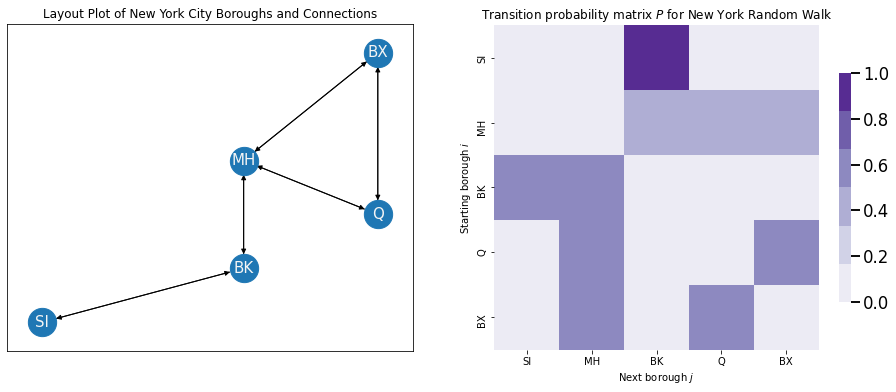

In [18]:
fig, axs = plt.subplots(1,2, figsize=(16, 6))

nx.draw_networkx(G, pos, ax=axs[0], with_labels=True, node_color="tab:blue", node_size = 800,
        font_size=15, font_color="whitesmoke", arrows=True)
axs[0].set_title("Layout Plot of New York City Boroughs and Connections")
heatmap(P, ax=axs[1], xticklabels=[0.5,1.5,2.5,3.5,4.5], yticklabels=[0.5,1.5,2.5,3.5,4.5])
axs[1].set_title("Transition probability matrix $P$ for New York Random Walk")
axs[1].set_xticklabels(["SI", "MH", "BK", "Q", "BX"])
axs[1].set_yticklabels(["SI", "MH", "BK", "Q", "BX"])
axs[1].set_ylabel("Starting borough $i$")
axs[1].set_xlabel("Next borough $j$")
fig;

To understand this transition probability matrix, let's think about the individual rows. Notice that if you are in Staten Island, there is only one borough you can go from here, so with probability $1$, you will visit its only neighbor: Brooklyn. If you are in Manhattan, you could go to any of its three neighbors (Brooklyn, Queens, or Bronx), with equal probability $\frac{1}{3}$. If you were in Brooklyn, you could visit any of its two neighbors (Manhattan or Staten Island) with equal probability $\frac{1}{2}$. This continues for each node in the network until you have successfully generated the transition probability matrix $P$.

There are a lot of interesting properties you can use the transition probability matrix $P$ to learn about, but we won't cover them all here. If you want some more details on transition probability matrices and Markov chains in general, we would recommend that you check out a book on stochastic processes, such as the author's favorite by Dean Isaacson, called [Markov Chains: Theory and Applications](https://www.amazon.com/dp/0471428620?tag=uuid10-20).

Next, let's use this transition probability matrix to generate a random walk on the New York City boroughs. As we mentioned, your hotel is in Manhattan, so you are going to start your random walk through the city here. In other words, $\mathbf s_0 = v_{MH}$. For your next step in the Markov chain, you will visit either Brooklyn, Bronx, or Queens with probability $\frac{1}{3}$, or Staten Island with probability $0$. In the following figure, we will show the nodes you could possibly go to in green, and the nodes you cannot go to in red. You choose between the three using the transition probabilities, and decided to go to Brooklyn, so we will indicate an "arrow" in green from Manhattan to Brooklyn:



## node2vec

node2vec is one such method. Instead of relying on taking eigenvectors or eigenvalues, like a Laplacian, node2vec uses a random walk to preserve the relationships between nodes and their *local neighborhoods*: all of the nodes which you can get to by walking along a small number of edges from your starting node. For example, take 

<AxesSubplot:>

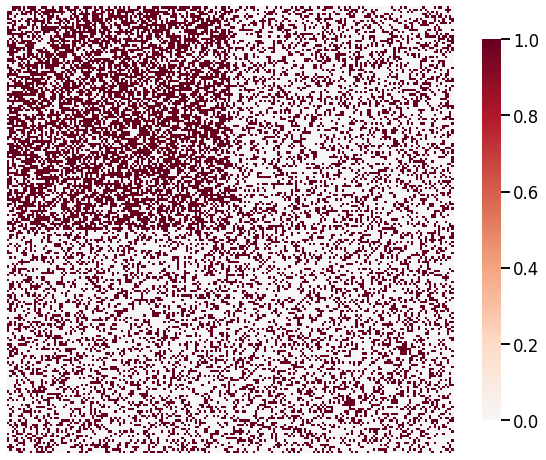

In [26]:
from graspologic.embed import node2vec_embed
from graspologic.simulations import sbm
from graspologic.plot import heatmap
import numpy as np
import networkx as nx

# Start with some simple parameters
N = 300  # Total number of nodes
n = N // 3  # Nodes per community
B = np.array([[.6, .3],
              [.3, .3]])  # Our block probability matrix

# Make our Stochastic Block Model
A, labels = sbm([n, n], B, return_labels = True)

heatmap(A)

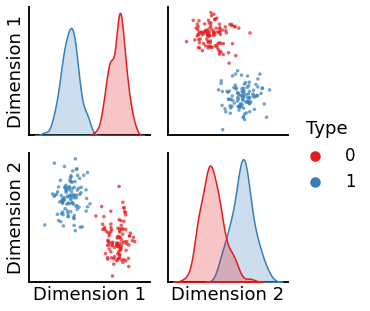

In [27]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

ase = ASE(n_components=2)
latents = ase.fit_transform(A)

pairplot(latents, labels=labels)

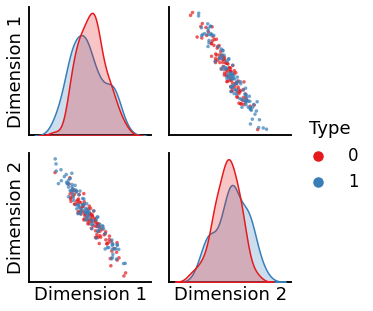

In [28]:
from graspologic.plot import pairplot

networkx_sbm = nx.Graph(A)
a, nodes = node2vec_embed(networkx_sbm, dimensions=2, walk_length=100)
pairplot(a, labels=labels)